### Notebook for the label transfer using `scNym` using the heart data as example.

- Notebook created by Dr. Carlos Talavera-López Ph.D - Institute of AI for Health, Helmholtz Zentrum Munchen. 
- 210701

### Check which GPU we've got

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul  5 11:34:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Check how much RAM we've got

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Set up environment

- Install packages

In [ ]:
!pip install scnym

- Load packages 

In [ ]:
import time
import numpy as np
import pandas as pd
import scanpy as sc

from tqdm import tqdm_notebook
from scnym.api import scnym_api

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.4
-----
PIL                         7.1.2
absl                        NA
astor                       0.8.1
bottleneck                  1.3.2
certifi                     2021.05.30
cffi                        1.14.5
chardet                     3.0.4
cloudpickle                 1.3.0
cycler                      0.10.0
cython_runtime              NA
dask                        2.12.0
dateutil                    2.8.1
debugpy                     1.0.0
decor

### Read in the **reference** scRNA-Seq data
- This is stored in GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
reference = sc.read_h5ad('/content/gdrive/My Drive/raw_data/single_cell/heart/hca_heart_global_ctl210226.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'Cells_Nuclei', 'combined'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

In [ ]:
sc.pp.normalize_total(reference, target_sum = 1e4)
sc.pp.log1p(reference)

normalizing counts per cell
    finished (0:00:02)


### Read in quiery dataset

In [ ]:
query = sc.read_h5ad('/content/gdrive/My Drive/INBOX/lisbon_2021/raw_data/hca_heart_fibroblasts_raw.h5ad')
query = query[:, reference.var_names]
query

View of AnnData object with n_obs × n_vars = 59341 × 22260
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

In [ ]:
sc.pp.normalize_total(query, target_sum = 1e4)
sc.pp.log1p(query)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


### Train `scNym` on reference data

In [ ]:
scnym_api(
    adata = reference,
    task = 'train',
    groupby = 'cell_states',
    out_path = '/content/gdrive/My Drive/data/reference/single_cell/heart_scnym/',
    config = 'no_new_identity',
)

CUDA compute device found.
No unlabeled data was found.
Did you forget to set some examples as `"Unlabeled"`?
Proceeding with purely supervised training.

X:  (452506, 22260)
y:  (452506,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Training...
Saving best model weights...
Saved best weights.
Saving best model weights...
Saved best weights.
>>>>>
Early stopping at epoch 47
>>>>>
Training complete.

Evaluating model.
EVAL LOSS:  0.669213499558174
EVAL ACC :  0.7797838721796203
Predictions | Labels
[[75 75]
 [59 59]
 [75 75]
 [56 56]
 [75 75]
 [75 75]
 [75 75]
 [76 75]
 [57 57]
 [74 74]
 [56 56]
 [37 37]
 [60 60]
 [75 75]
 [33 33]]


### Predict labels on lung dataset

In [ ]:
scnym_api(
    adata = query,
    task = 'predict',
    key_added = 'scNym',
    trained_model = '/content/gdrive/My Drive/data/reference/single_cell/heart_scnym/',
    out_path = '/content/gdrive/My Drive/data/reference/single_cell/scnym_output/',
    config = 'no_new_identity',
)

CUDA compute device found.


Finding cell types:   0%|          | 0/58 [00:00<?, ?it/s]

Loaded model predicting 79 classes from 22260 features
['Adip1' 'Adip2' 'Adip3' 'Adip4' 'B' 'B_plasma' 'CD14+Mo' 'CD4+T_Tfh'
 'CD4+T_Th1' 'CD4+T_Th17' 'CD4+T_Th2' 'CD4+T_act' 'CD4+T_naive'
 'CD4+T_reg' 'CD69+Mo' 'CD8+T_cytox' 'CD8+T_em' 'CD8+T_te' 'CD8+T_trans'
 'Cycling_T/NK' 'DC2' 'DOCK4+aMØ' 'DOCK4+vMØ' 'EC10_CMC-like' 'EC1_cap'
 'EC2_cap' 'EC3_cap' 'EC4_immune' 'EC5_art' 'EC6_ven' 'EC7_atria' 'EC8_ln'
 'EC9_FB-like' 'FB1' 'FB2' 'FB3' 'FB4' 'FB5' 'FB6' 'ILC' 'LYVE1+MØ1'
 'LYVE1+MØ2' 'M2MØ' 'MAIT-like' 'Mast' 'Meso' 'MoMø' 'NC1' 'NC2' 'NC3'
 'NC4' 'NC5' 'NC6' 'NK_CD16hi' 'NK_CD56hi' 'NØ' 'PC1_vent' 'PC2_atria'
 'PC3_str' 'PC4_CMC-like' 'SMC1_basic' 'SMC2_art' 'TREM2+MØ' 'aCM1' 'aCM2'
 'aCM3' 'aCM4' 'aCM5' 'gdT' 'nøMo' 'pDC' 'proIMØ' 'unclassfied.1'
 'unclassfied.2' 'vCM1' 'vCM2' 'vCM3' 'vCM4' 'vCM5']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████| 58/58 [00:11<00:00,  5.24it/s]


Extracting model embeddings...


### Visualise labels on `scNym` computed manifold

In [ ]:
!rm -rf /usr/local/lib/python3.7/dist-packages/numpy*
!pip install numpy

     |████████████████████████████████| 15.7MB 325kB/s 
ERROR: scnym 0.3.2 requires numpy-groupies==0.9.13, which is not installed.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.14.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.2.1 which is incompatible.
ERROR: scnym 0.3.2 has requirement numpy==1.18.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.0.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.14.0 which is incompa

computing neighbors


/usr/local/lib/python3.7/dist-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.7/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.7/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:25)


... storing 'scNym' as categorical


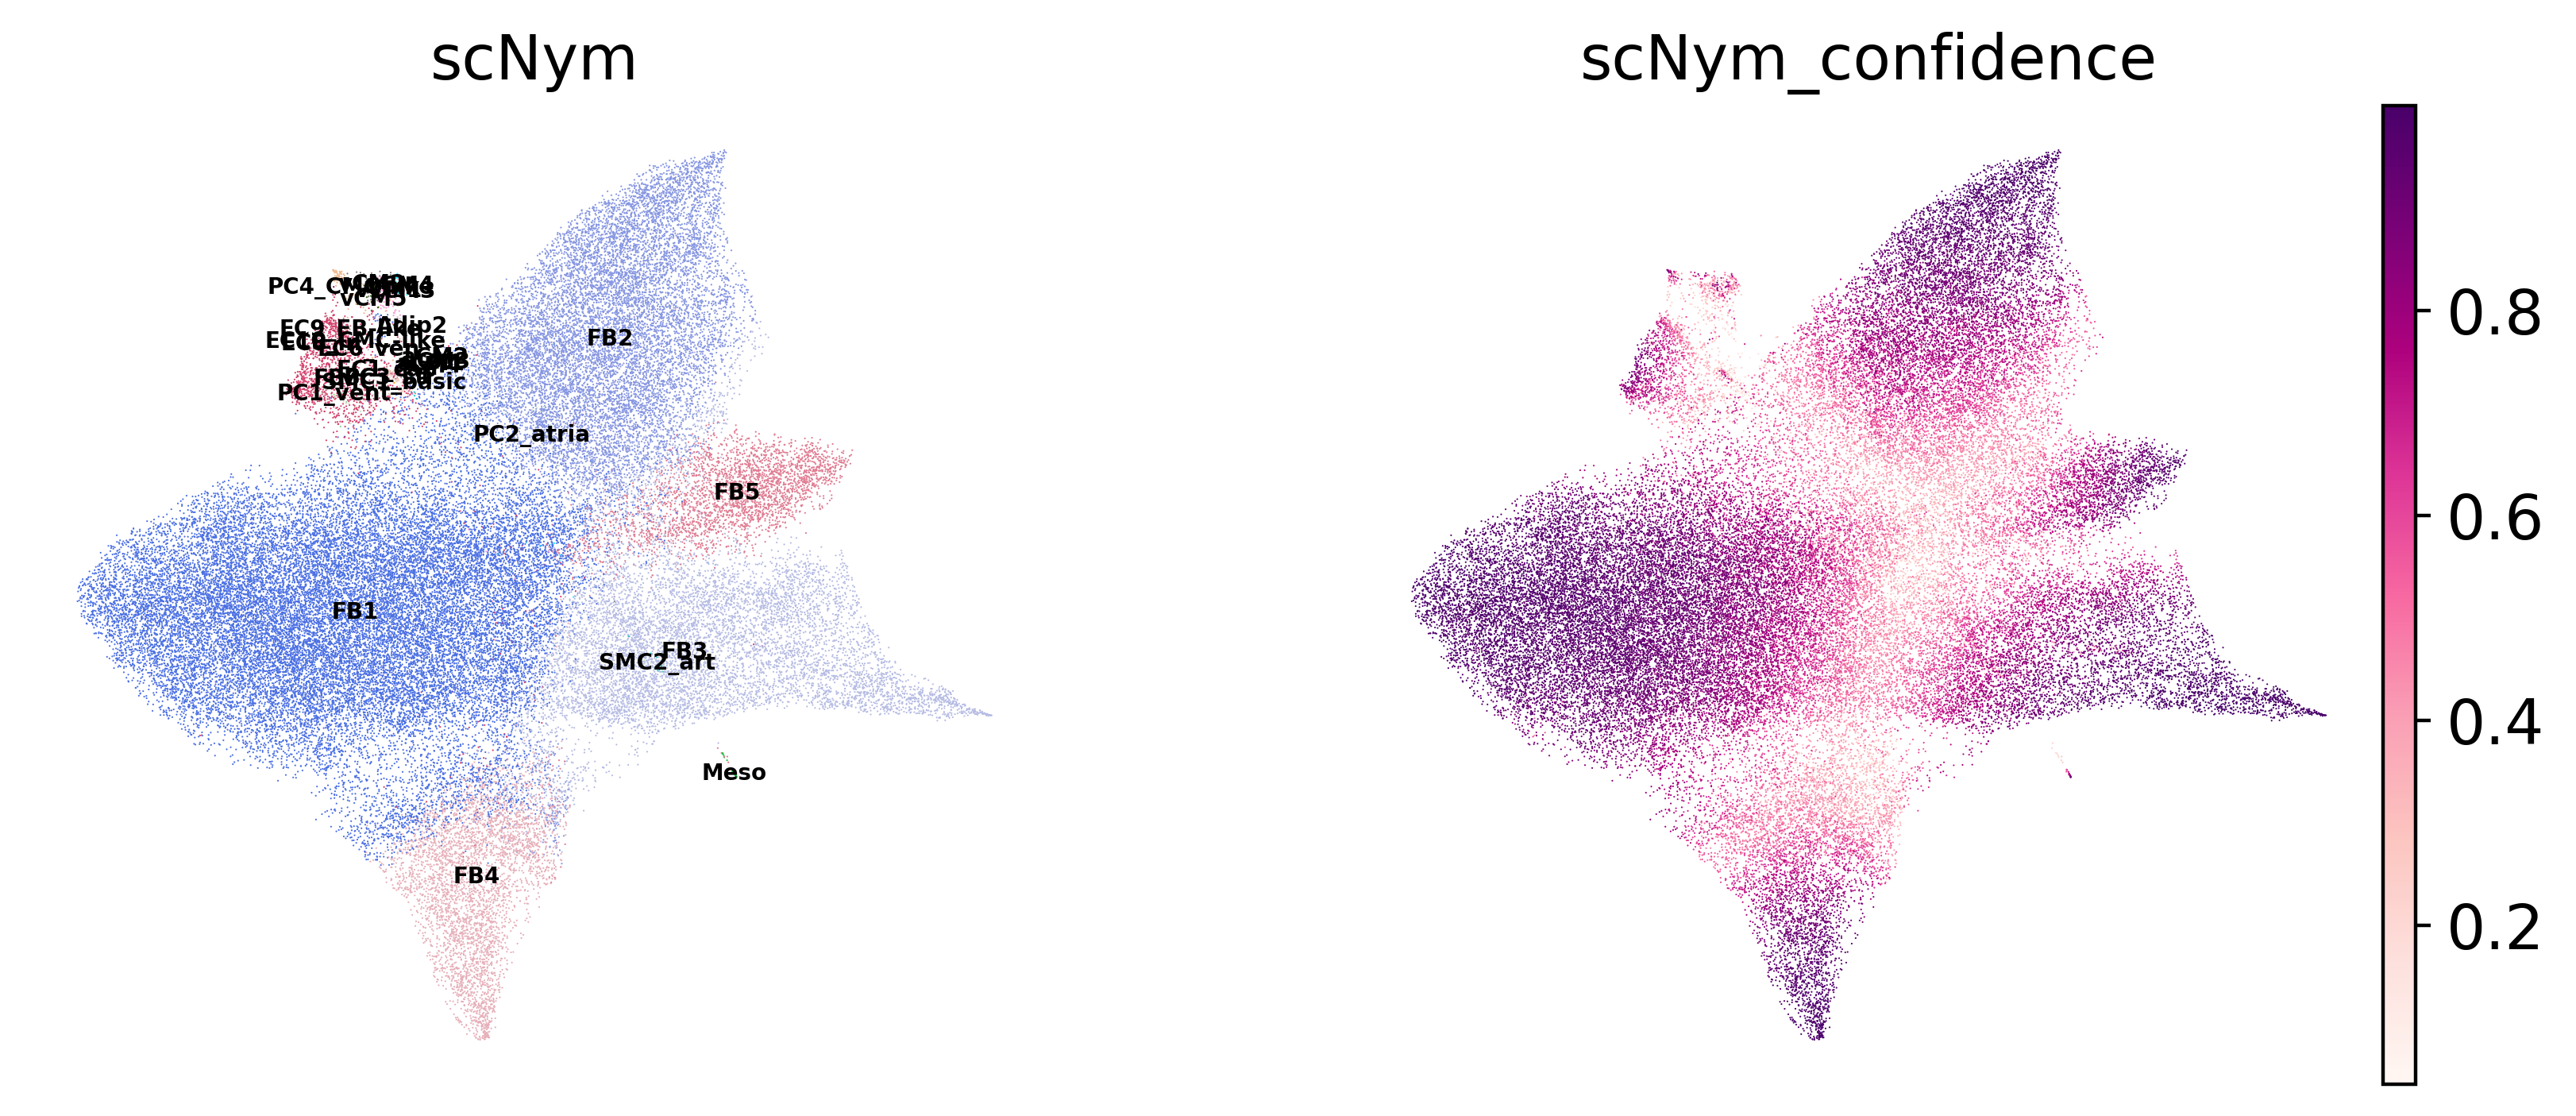

In [ ]:
sc.pp.neighbors(query, use_rep = 'X_scnym', n_neighbors = 20)
sc.tl.umap(query, min_dist = 0.3, spread = 1, random_state = 1712)
sc.pl.umap(query, color = ['scNym', 'scNym_confidence'], size = 0.6, frameon = False, legend_loc = 'on data', legend_fontsize = 5)

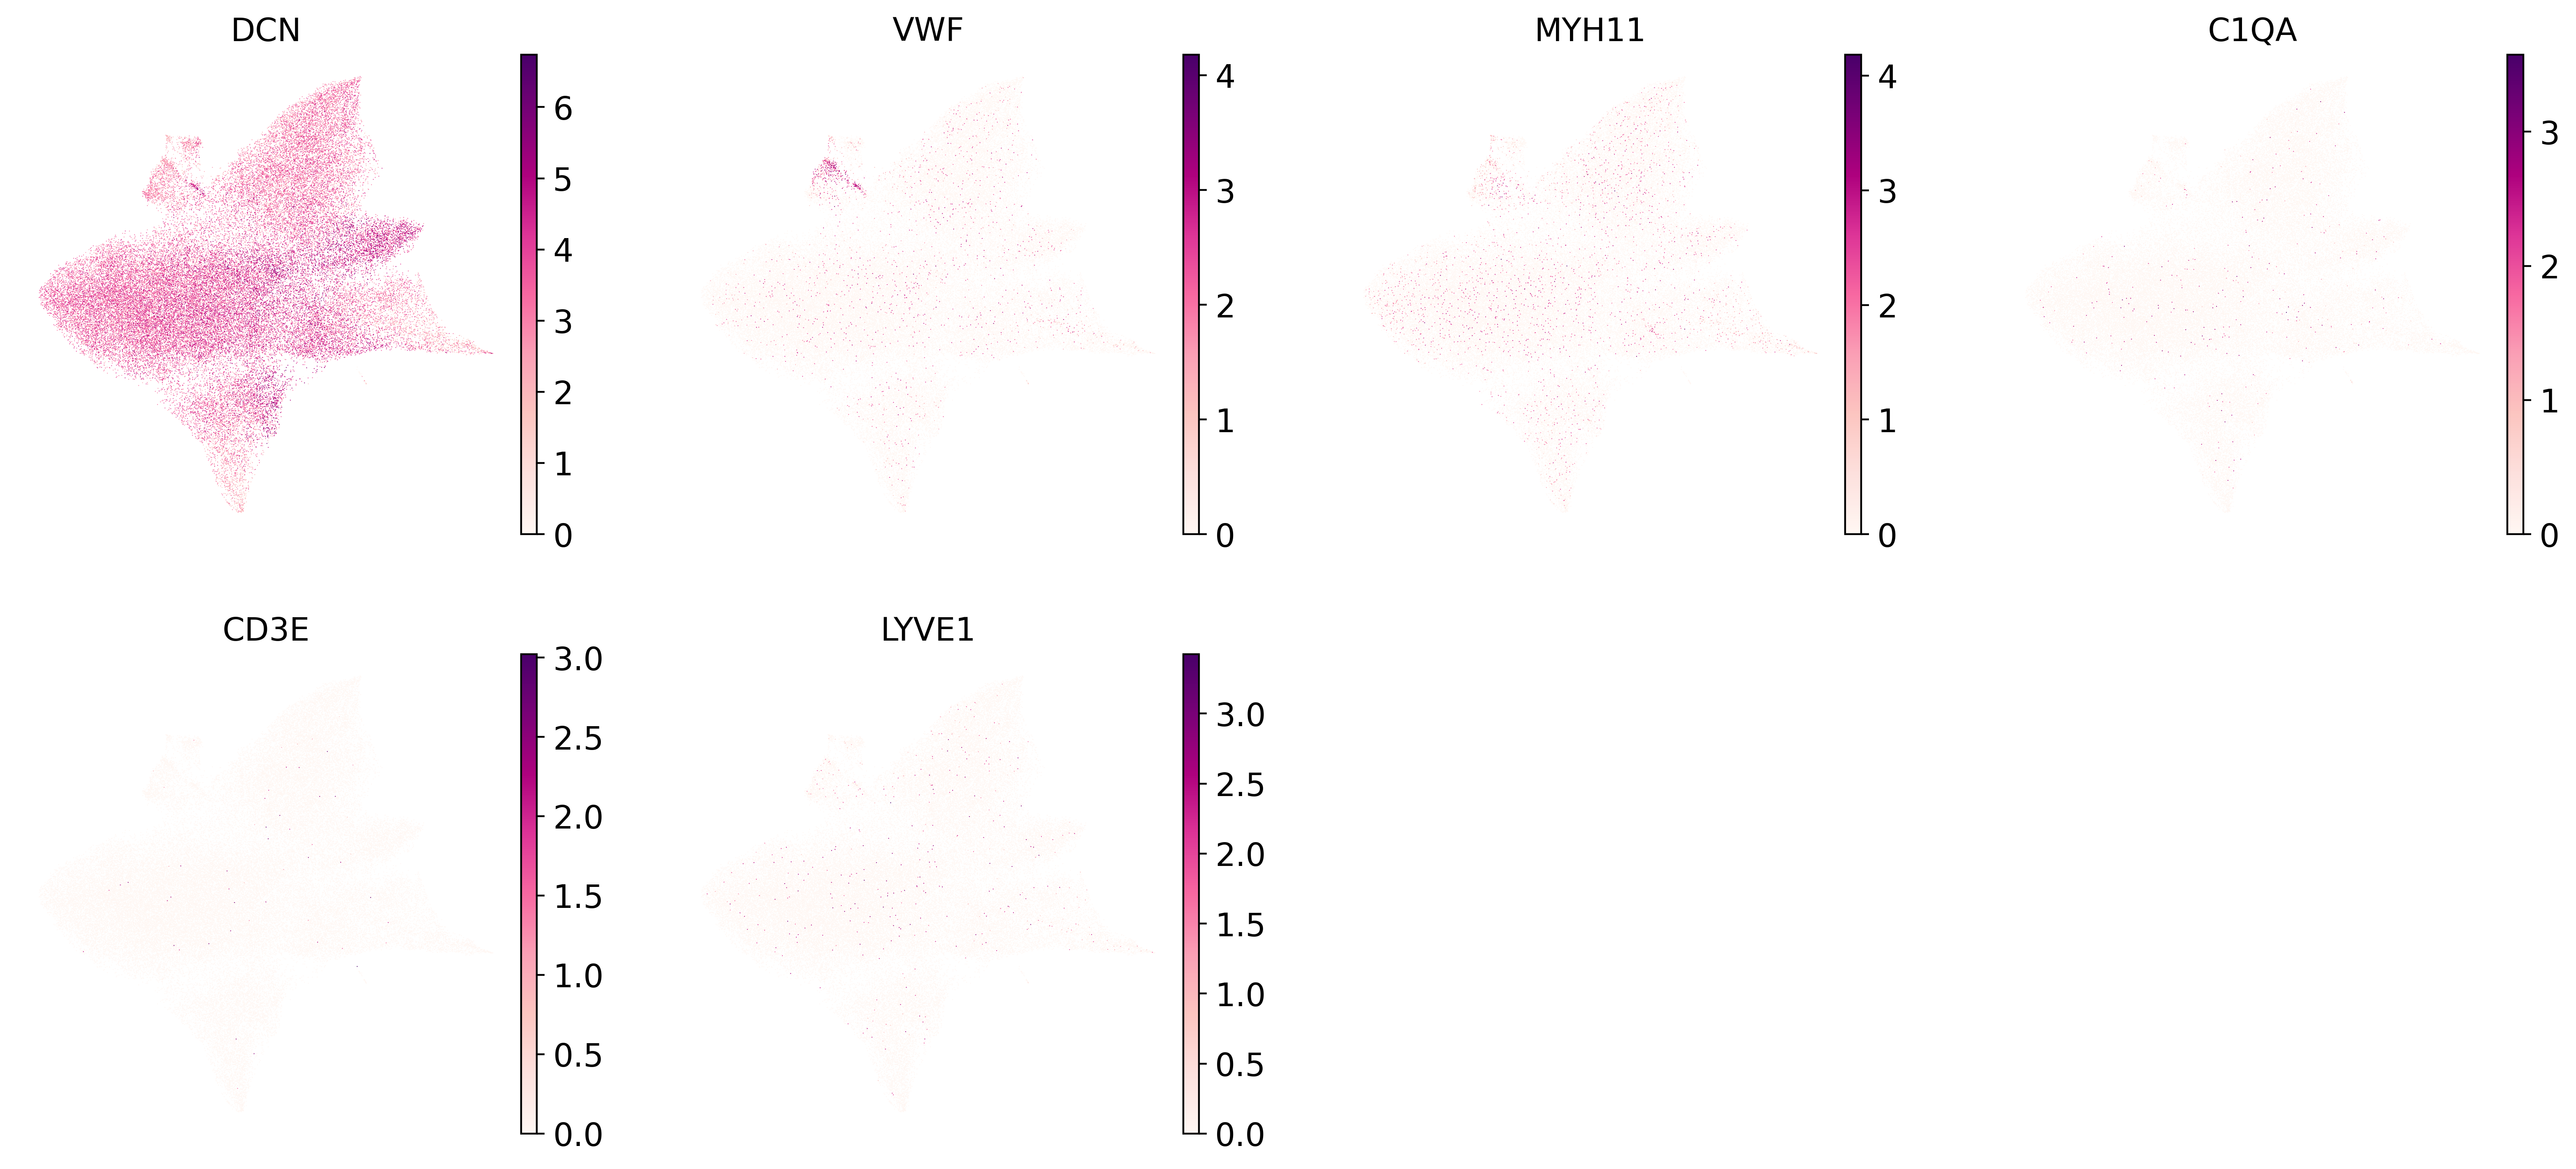

In [ ]:
sc.pl.umap(query, color = ['DCN', 'VWF', 'MYH11', 'C1QA', 'CD3E', 'LYVE1'], size = 0.6, frameon = False, legend_fontsize = 5)